In [ ]:
import pandas as pd

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00502/online_retail_II.xlsx"

df = pd.read_excel(url, sheet_name=1)

df.head()


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
# Remove missing Customer ID
df = df.dropna(subset=['Customer ID'])

# Remove cancelled invoices (start with 'C')
df = df[~df['Invoice'].astype(str).str.startswith('C')]

df.shape


(397925, 8)

In [ ]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


In [ ]:
df['TotalPrice'] = df['Quantity'] * df['Price']


In [ ]:
df.head()


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [ ]:
reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
reference_date


Timestamp('2011-12-10 12:50:00')

In [ ]:
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,
    'Invoice': 'nunique',
    'TotalPrice': 'sum'
})

rfm.columns = ['Recency', 'Frequency', 'Monetary']

rfm.head()


,Recency,Frequency,Monetary
Customer ID,,,
12346.0,326,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40


In [16]:
# Rank values first to avoid duplicate bin issues
rfm['R_Score'] = pd.qcut(
    rfm['Recency'].rank(method='first'),
    5,
    labels=[5,4,3,2,1]
)

rfm['F_Score'] = pd.qcut(
    rfm['Frequency'].rank(method='first'),
    5,
    labels=[1,2,3,4,5]
)

rfm['M_Score'] = pd.qcut(
    rfm['Monetary'].rank(method='first'),
    5,
    labels=[1,2,3,4,5]
)


In [17]:
rfm['RFM_Score'] = (
    rfm['R_Score'].astype(str) +
    rfm['F_Score'].astype(str) +
    rfm['M_Score'].astype(str)
)

rfm.head()


,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
Customer ID,,,,,,,
12346.0,326,1,77183.60,1,1,5,115
12347.0,2,7,4310.00,5,5,5,555
12348.0,75,4,1797.24,2,4,4,244
12349.0,19,1,1757.55,4,1,4,414
12350.0,310,1,334.40,1,1,2,112


In [18]:
def segment(row):
    if row['R_Score'] == 5 and row['F_Score'] >= 4:
        return "Champions"
    elif row['R_Score'] >= 4 and row['F_Score'] >= 3:
        return "Loyal Customers"
    elif row['R_Score'] <= 2:
        return "At Risk"
    else:
        return "Potential"

rfm['Segment'] = rfm.apply(segment, axis=1)

rfm['Segment'].value_counts()


,count
Segment,
At Risk,1736
Potential,1178
Loyal Customers,792
Champions,633


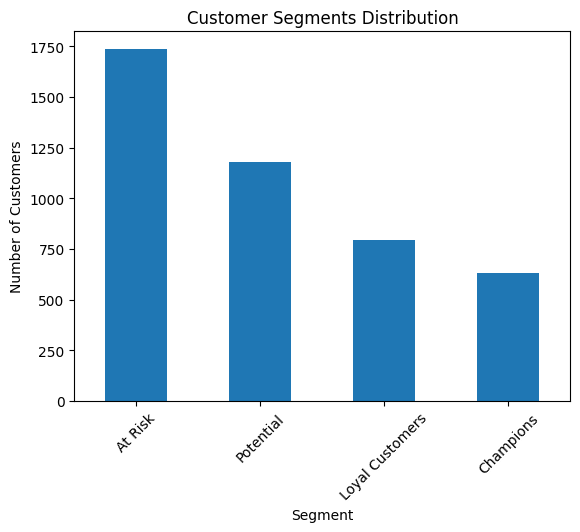

In [19]:
import matplotlib.pyplot as plt

rfm['Segment'].value_counts().plot(kind='bar')
plt.title("Customer Segments Distribution")
plt.xlabel("Segment")
plt.ylabel("Number of Customers")
plt.xticks(rotation=45)
plt.show()


In [20]:
rfm.to_csv("rfm_segments.csv")
